In [57]:
import pandas as pd
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import os
import osmnx as ox
import dotmap
import sys
import random
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]

import networkx as nx #graphs
cwd = os.getcwd()

from ExMAS.utils import inData as inData
from dotmap import DotMap

df1 = pd.read_csv('City_requests.csv') #demografia Wzgórza Krzesławickie
df = df1.loc[df1.index.repeat(df1.ogolem)].reset_index(drop=True) #repeat Rows N times (equal "ogolem"): N Rows = N people 

params = ExMAS.utils.get_config('default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths

inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph


In [58]:
frac = 0.1
params.shared_discount = 0.3
params.nP = int(frac * len(df))
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 8
params.VoT = 0.003
params.price = 1.5

In [59]:
sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
sample.shape

sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['y'], row['x'])), axis = 1) 

In [60]:
inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests

In [61]:
my_requests = inData.requests
my_requests.destination = ox.get_nearest_node(inData.G,[50.09516, 20.06522])
my_requests["origin"] = sample.origin.values

my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)

my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1)
#my_requests.ttrav = (pd.to_timedelta(my_requests.ttrav) / params.speeds.ride).dt.floor('1s')
my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
my_requests = inData.requests
inData.requests = my_requests
inData.requests.to_csv("check.csv")

In [62]:
inData = ExMAS.main(inData, params)

KPIs = inData.sblts.res.to_frame()[:23]

KPIs['description']  = ExMAS.utils.KPIs_descriptions
KPIs.columns = ['KPI', 'description']
KPIs

10-01-24 11:40:13-INFO-Initializing pairwise trip shareability between 266 and 266 trips.
10-01-24 11:40:13-INFO-creating combinations
10-01-24 11:40:13-INFO-70490	 nR*(nR-1)
10-01-24 11:40:14-INFO-Reduction of feasible pairs by 96.84%
10-01-24 11:40:14-INFO-Degree 2 	Completed
10-01-24 11:40:14-INFO-trips to extend at degree 2 : 4640
10-01-24 11:40:21-INFO-At degree 2 feasible extensions found out of 7083 searched
10-01-24 11:40:21-INFO-Degree 3 	Completed
10-01-24 11:40:21-INFO-trips to extend at degree 3 : 7083
10-01-24 11:40:35-INFO-At degree 3 feasible extensions found out of 10670 searched
10-01-24 11:40:35-INFO-Degree 4 	Completed
10-01-24 11:40:35-INFO-trips to extend at degree 4 : 10670
10-01-24 11:40:55-INFO-At degree 4 feasible extensions found out of 9411 searched
10-01-24 11:40:55-INFO-Degree 5 	Completed
10-01-24 11:40:55-INFO-trips to extend at degree 5 : 9411
10-01-24 11:41:09-INFO-At degree 5 feasible extensions found out of 4125 searched
10-01-24 11:41:09-INFO-Degree 

,KPI,description
VehHourTrav,20829,total travel time of vehicles (with travellers...
VehHourTrav_ns,52367,as above yet in non-shared scenarion
PassHourTrav,59364,total travel time of passengers
PassHourTrav_ns,52367,as above yet in non-shared scenarion
PassUtility,597.65865,total (dis)utility of passengers
PassUtility_ns,629.436,as above yet in non-shared scenarion
mean_lambda,0.61601,mean vehicle cost reduction (lambda) over shar...
revenue_s,54985.35,total fares paid by travellers sharing
revenue_ns,78550.5,as above yet in non-shared scenarion
Fare_Discount,-0.3,relative revenue reduction


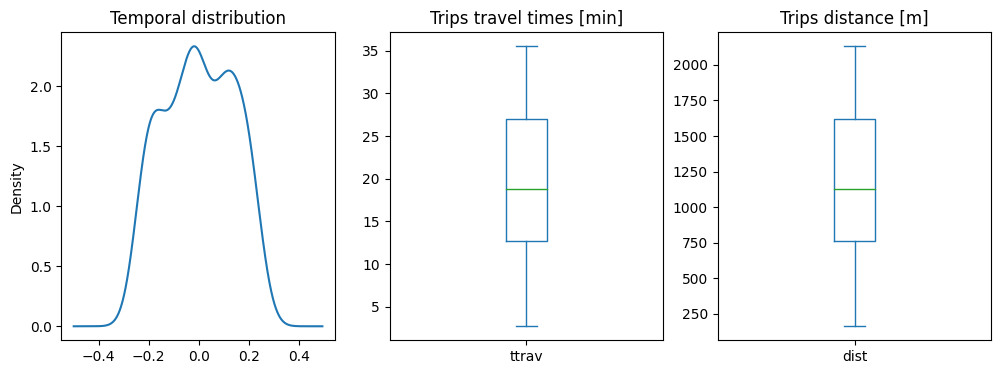

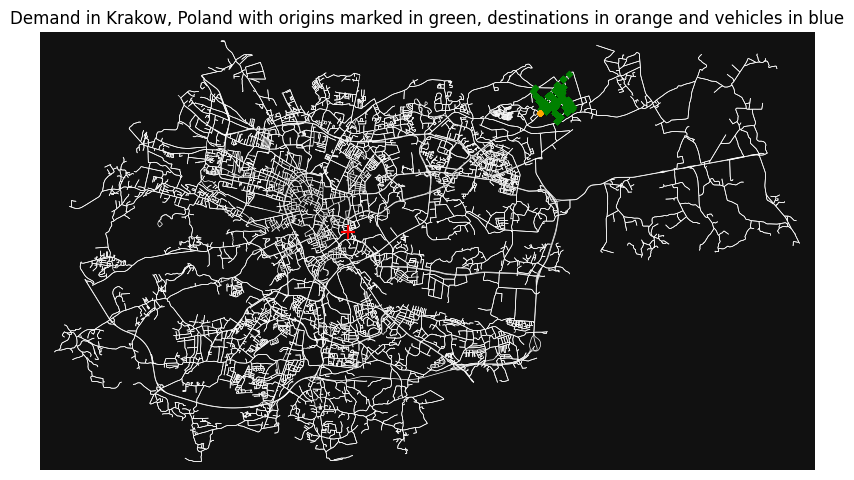

In [63]:
ExMAS.utils.plot_demand(inData, params)

In [46]:
KPIs.to_csv("KPIs.csv")